# Article sélectionné : 
# "**Un algorithme optimal de la ligne de partage des eaux**"

```
F.Meyer
Centre de Morphologie Mathématique
Ecole des Mines
35, Rue Saint Honoré
77305 FONTAINEBLEAU
FRANCE
```

Projet réalisé par **Quentin Misslin** dans le cadre du cours de Traitement d'Image et Géométrie Discrète (encadrement : **Mazo Loic**).


In [1]:
# imports
import skimage
import numpy as np # tableaux
import scipy.ndimage as scp # correlation et convolution
import matplotlib.pyplot as plt # visionneur et tracés

from skimage import data # petite banque d'images
from skimage import util # conversions entier <-> flottants etc.
from skimage import filters as flt # 'filter' ou 'filters' suivant la version de skimage
from skimage import morphology,segmentation

from skimage.morphology import watershed
from skimage.feature import peak_local_max

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


# Introduction
La ligne de partage des eaux est une technique extrêmement puissante de segmentation. Voici ci-dessous une fonction permetant son application sur une **image donnée en paramètre**. Le second argument de la fonction est le **h_min**, il s'agit d'un filtre qui permet de ne pas prendre en compte les minima du gradeint non significatifs (ceux en dessous **h_min**).



In [0]:
def LPE(I, h_min, I_origin = None):

  print(I.dtype)
  if(I_origin is None):
    I_origin = I

  # calcul du gradient morphologique
  B=morphology.disk(1)
  g=morphology.dilation(I,B)-morphology.erosion(I,B)
  gi=g-morphology.erosion(I,B)

  # filtre h-min pour filtrer les minima du gradient non significatifs
  h=h_min
  # les valeurs de gh vont dépasser les bornes du uint8 : on la passe en uint16
  gh=g.astype('uint16')+h

  # puis on effectue un clipping sur les valeurs pour reconvertir l'image en uint8
  gh=np.clip(gh,0,255).astype('uint8')

  # reconstruction géodésique par érosion de g+h dans g
  gh=morphology.reconstruction(gh,g,method='erosion')

  plt.subplot(1,2,1)
  plt.imshow(gh)

  # extraction des minima régionaux
  m=morphology.local_minima(gh)
  # étiquetage des minima 
  # l : tableau avec les labels étiquetés
  # n : nombre de labels (minima)
  l,n=scp.label(m)
  print("Nombre de labels :",n)
  # ligne de partage des eaux sur gh à partir du marqueur l
  s=morphology.watershed(gh,l)
  # superposition des frontières des régions sur l'image de départ
  b=skimage.segmentation.mark_boundaries(I_origin,s)

  plt.subplot(1,2,2)
  plt.imshow(b)


On remarque ci-dessous que la segmentation est tout à fait correcte sur l'image "**house.png**", même avec une suppression à 15 des minimas non significatifs du gradient.

uint8
Nombre de labels : 114


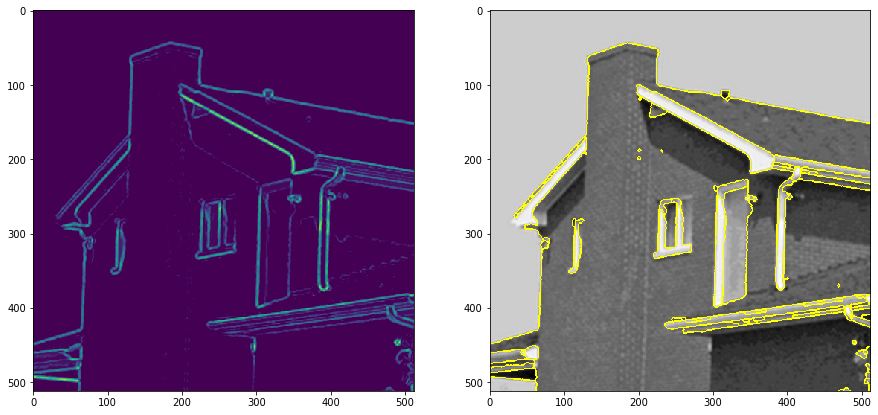

In [4]:
LPE(skimage.io.imread('house.png'), 15)

Néanmoins, on ne peut utiliser directement l'algorithme de ligne de partage des eaux pour des images plus compliquées (ou bruitées), car il se produit une très sévère sur-segmentation de l'image.

Voici un exemple de ce problème sur l'image "**pepperAndSalt.png**", et ce problème persiste même avec un suppression à 80 des minimas non significatifs. On remarque en effet que chaque minimum régional de l'image gradient génère un bassin versant, ce qui donne des résultats inutilisables.

uint8
Nombre de labels : 8011


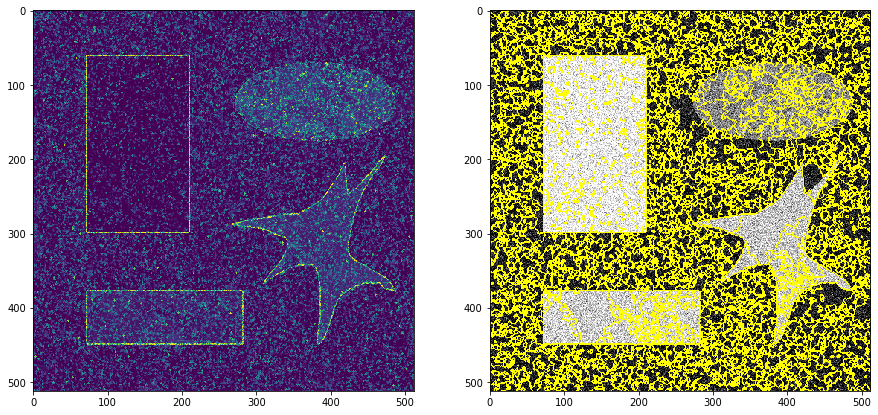

In [5]:
LPE(skimage.io.imread('pepperAndSalt.png'), 80)

# Solution : un filtre morphologique préalable

Pour palier à ce problème de sur-segmentation, l'article de recherche propose l'utilisation d'un filtre morphologique préalable.

Ce dernier est d'une ouverture, suivi d'une fermeture. Il est cité que nous pouvons prendre pour ouverture le résultat d'une reconstruction de grain numérique de l'image initiale en utilisant une image érodée comme image marqueur.

En appliqaunt cette ouverture suivit d'une fermeture, on observe une nette amélioration des résultats, et ce même avec un filtre plus bas (à 29) des minimas non significatifs.

uint8
Nombre de labels : 245


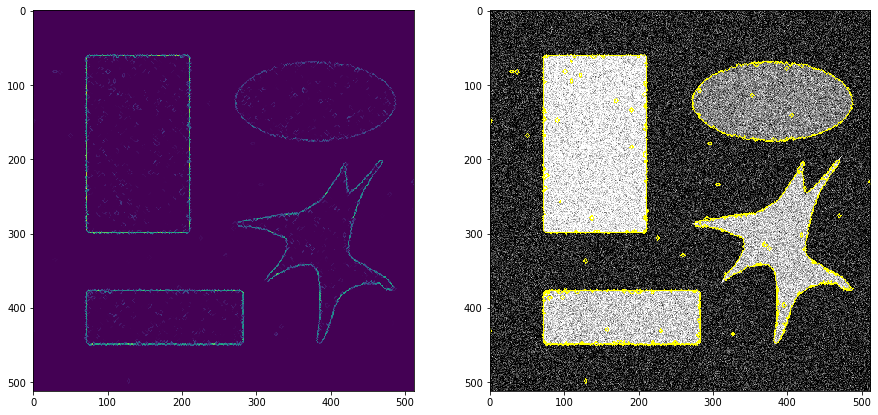

In [6]:
I=skimage.io.imread('pepperAndSalt.png')
disk=morphology.disk(2)

J=morphology.opening(I,disk)
K=morphology.closing(J,disk)

LPE(K, 29, I)

# Utilisation de marqueurs

L'article non dit "Sur l'image bruité, la sur-segmentation s'est porduite lors de la ligne de partage des eaux, parce qu'il y avait un grand nombre de sources d'inondation différente".

En effet, le bruit de l'image engendre une sur-production de bassins versans, ce qui provoque un trop grand nombre de sources d'inondation, et de ce fait un trop grand nombre de lignes de partages des eaux lorsque l'on remplit les bassins.

L'article propose ainsi la mise en place de marqueur, positionnés à l'intérieur des objets à reconnaitres. L'inondation serait alors effectuée à partir de ces marqueurs, et un bassin versan voisin possédant un marqueur serait alors inondé à partir de ce marqueur.

Une simplification encore plus drastique s'impose pour pouvoir extraire facilement les marqueurs. Ici nous effectuons par exemple une dilatation suivit d'une fermeture.


Text(0.5, 1.0, 'Seuillage sur les distances')

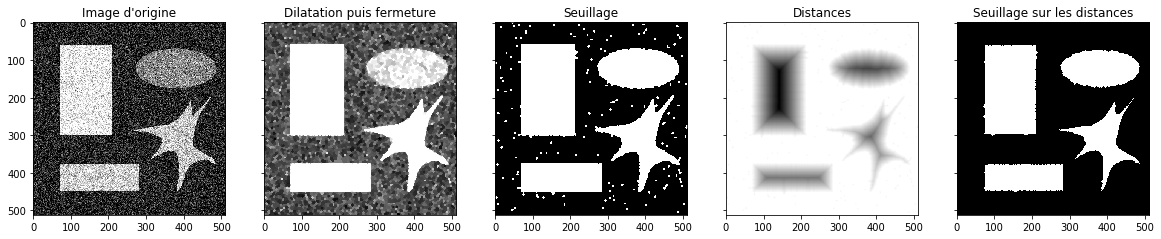

In [10]:
disk = morphology.disk(3)
I = skimage.io.imread('pepperAndSalt.png')
J = morphology.closing(morphology.dilation(I,disk),disk)
K = uint8(J>190)
L = -scp.distance_transform_edt(K)
M = uint8(L<-4)

fig, axes = plt.subplots(ncols=5, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(I, cmap=plt.cm.gray)
ax[0].set_title('Image d\'origine')
ax[1].imshow(J, cmap=plt.cm.gray)
ax[1].set_title('Dilatation puis fermeture')
ax[2].imshow(K, cmap=plt.cm.gray)
ax[2].set_title('Seuillage')
ax[3].imshow(L, cmap=plt.cm.gray)
ax[3].set_title('Distances')
ax[4].imshow(M, cmap=plt.cm.gray,vmin=0,vmax=1)
ax[4].set_title('Seuillage sur les distances')


# Autre utilisation de la LPE : séparation de particules

Comme l'article le cite page 851, une autre application de la LPE est la séparation de particules, c'est à dire la séparation de plusieurs noyaux accolés.

On peut effectuer ce procédé comme suit, en générant les marqueurs à partir des maximas locaux des distances par rapport au fond (noir) de l'image.


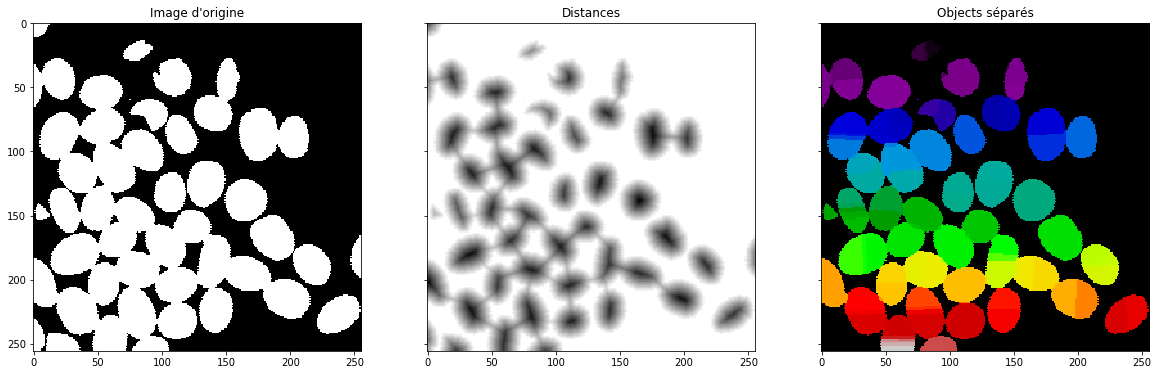

In [13]:
image = skimage.io.imread('coffee.gif') 

distance = scp.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = scp.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Image d\'origine')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Objects séparés')
plt.show()

# Un algorithme optimal de LPE

La suite de l'article présente la mise en place d'une file d'attente hiérarchique pour le traitement lors de l'inondation du relief.

Voici ci-dessous un exemple d'implémentation de cette file en python.

In [0]:
class HierarchicalQueue:
  # Constructeur de liste de file hiérarchique
  def __init__(self):
    self.queue = []
    self.el_id_generator = 0

  # Affichage de liste de file hiérarchique
  def __str__(self):
    res = "[\n"
    for i in self.queue:
      res += "\t" + str(i) + "\n"
    res += "]\n"
    return res
  def __repr__(self):
    return self.__str__()

  # Insertion d'un élément
  def insert(self, lvl):
    el = E(lvl, self.el_id_generator)
    self.el_id_generator += 1
    index = self.searchLevel(el.level)

    # Création de la file hiérarchique si elle n'existe pas
    if index == -1:
      q = Queue(el.level)
      self.queue.append(q)

    # Réccupération de la file hiérarchique si elle existe
    else:
      q = self.queue[index]
    
    # Insertion de l'élément
    q.insert(el)

    return el

  # Cherche si un niveau de file hiérarchique existe déjà
  def searchLevel(self, lvl):
    for i in range(len(self.queue)):
      if self.queue[i].level == lvl:
        return i
    return -1

  # Récupération de l'élément le plus ancien de la file la plus prioritaire
  def pop(self):

    # Si il n'y a plus de file d'attente
    if(len(self.queue) == 0):
      print("There are no more items pending.")
      return None
    
    # Réccupération de la file d'attente la plus prioritaire
    max_level = self.queue[0].level
    max_index = 0
    for i in range(len(self.queue)):
      if(self.queue[i].level > max_level):
        max_level = self.queue[i].level
        max_index = i

    # On retourne l'élément le plus ancien de la file la plus prioritaire
    el = self.queue[max_index].pop()

    # Suppression de la file hiérarchique si cette dernière est vide
    if(len(self.queue[max_index].queue) == 0):
      del self.queue[max_index]

    return el

class Queue:
  # Constructeur de file
  def __init__(self, lvl):
    self.level = lvl
    self.queue = []

  # Affichage de file
  def __str__(self):
     return "Level " + str(self.level) + ":" + str(self.queue)
  def __repr__(self):
    return self.__str__()

  # Insertion d'un élément dans la file
  def insert(self, el):
    if(el.level == self.level):
      self.queue.append(el)
    else:
      print("Cannot insert element " + str(el.id)+ " with level " + 
            str(el.level) + " in queue with level " + str(self.level))
  
  # Réccupération de l'élément le plus ancien de la file d'attente
  def pop(self):
    if(len(self.queue) == 0):
      print("There are no more elements in the level " + str(self.level) 
            + " hierarchy queue")
      return None
    el = self.queue[0]
    del self.queue[0]
    return el

class E:
  # Constructeur de file
  def __init__(self, lvl, id):
    pre = ""
    if(id < 10) : 
      pre = "0"
    #print("New element with id " + pre + str(id) + " and level " + str(lvl))
    self.level = lvl
    self.id = id

  # Affichage de l'element
  def __str__(self):
     return "E" + str(self.id)
  def __repr__(self):
    return self.__str__()

def createHqExample():

  hq = HierarchicalQueue()
  # Insertion de 5 élément de niveau 1
  for i in range(5): hq.insert(1)
  # Insertion de 2 élément de niveau 2
  for i in range(2): hq.insert(2)
  # Insertion de 5 élément de niveau 3
  for i in range(5): hq.insert(3)
  # Insertion de 4 élément de niveau 4
  for i in range(4): hq.insert(4)
  # Insertion de 3 élément de niveau 5
  for i in range(3): hq.insert(5)
  return hq

Ci-dessus de trouve l'implémentation de file hiérarchique proposée dans l'article. Comme sur la figure 7A de la page 853, on se retrouve avec la file hiérarchique ci-dessous :


In [15]:
hq = createHqExample()
print(hq)

[
	Level 1:[E0, E1, E2, E3, E4]
	Level 2:[E5, E6]
	Level 3:[E7, E8, E9, E10, E11]
	Level 4:[E12, E13, E14, E15]
	Level 5:[E16, E17, E18]
]



Ensuite, nous pouvons illustrer les même étapes que celles décrites sur cette même figure, c'est à dire **l'insertion d'un élément de niveau 2**, la **réccupération de l'élément le plus ancien de la file la plus prioritaire**, **la suppression de liste vide**, et enfin l'**insertion d'un élément** en liste prioritaire.


In [16]:
hq = createHqExample()

# Insertion d'un élément de niveau 2
print("Inserting " + str(hq.insert(2)))
print(hq)

# Réccupération des éléments les plus prioritaires
print("Pop : " + str(hq.pop()))
print(hq)
print("Pop : " + str(hq.pop()))
print(hq)

# Suppression de liste vide (ici la liste de niveau 5)
print("Pop : " + str(hq.pop()))
print(hq)

# On passe à la liste la plus prioritaire (la liste de niveau 4)
print("Pop : " + str(hq.pop()))
print(hq)

# Insertion en liste de niveau 4 (l'élément est ajouté en queue de liste)
print("Inserting " + str(hq.insert(4)))
print(hq)

# Insertion en liste de niveau 5 (l'élément est ajouté en tête car la liste
# de niveau hiérarchique 5 est vide)
print("Inserting " + str(hq.insert(5)))
print(hq)

Inserting E19
[
	Level 1:[E0, E1, E2, E3, E4]
	Level 2:[E5, E6, E19]
	Level 3:[E7, E8, E9, E10, E11]
	Level 4:[E12, E13, E14, E15]
	Level 5:[E16, E17, E18]
]

Pop : E16
[
	Level 1:[E0, E1, E2, E3, E4]
	Level 2:[E5, E6, E19]
	Level 3:[E7, E8, E9, E10, E11]
	Level 4:[E12, E13, E14, E15]
	Level 5:[E17, E18]
]

Pop : E17
[
	Level 1:[E0, E1, E2, E3, E4]
	Level 2:[E5, E6, E19]
	Level 3:[E7, E8, E9, E10, E11]
	Level 4:[E12, E13, E14, E15]
	Level 5:[E18]
]

Pop : E18
[
	Level 1:[E0, E1, E2, E3, E4]
	Level 2:[E5, E6, E19]
	Level 3:[E7, E8, E9, E10, E11]
	Level 4:[E12, E13, E14, E15]
]

Pop : E12
[
	Level 1:[E0, E1, E2, E3, E4]
	Level 2:[E5, E6, E19]
	Level 3:[E7, E8, E9, E10, E11]
	Level 4:[E13, E14, E15]
]

Inserting E20
[
	Level 1:[E0, E1, E2, E3, E4]
	Level 2:[E5, E6, E19]
	Level 3:[E7, E8, E9, E10, E11]
	Level 4:[E13, E14, E15, E20]
]

Inserting E21
[
	Level 1:[E0, E1, E2, E3, E4]
	Level 2:[E5, E6, E19]
	Level 3:[E7, E8, E9, E10, E11]
	Level 4:[E13, E14, E15, E20]
	Level 5:[E21]
]



# Conclusion

L'article présente l'utilité de la ligne de partage des eaux dans un premier temps. J'ai tenté au mieux d'illustrer chacun des points qui sont abordés dans l'article.

Ce dernier montre ensuite deux methodes permetant la mise en place d'un algorithme de files hiérarchiques (l'exemple de la première methode étant implémenté ci-dessus). Ces methodes sont ensuite utiles à la mise en place de la LPE. 

Cependant, l'article ne fait pas d'exemple concret de ces méthodes sur des images réelles. Ainsi ne sachant pas trop comment procéder pour que ça soit le cas, j'ai laissé l'algorithme et les tests en l'état.

